## LSTM (Using Single Step Approach)

* Single-step approach predicts only the next step (t + delta t) and compares directly with actual values. 

* No feedback loop where predictions become inputs for the next step. 

* More precise evaluation since predictions are independently tested against y_test

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Load dataset
train_data = pd.read_csv('TE1.csv')
test_data = pd.read_csv('TR1.csv')

# Normalize `IP Delay (ms)`
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

print(train_data.head())  # Check the normalized data


     SN  IP Delay (ms)  Normalized IP Delay
0  9001      20.951986             0.839265
1  9002      20.885944             0.827640
2  9003      20.895958             0.829402
3  9004      20.812035             0.814630
4  9005      20.740986             0.802124


In [19]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Sequence of `sequence_length`
        y.append(data[i+sequence_length])   # Target value (next time step)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 10

# Prepare training sequences
train_values = train_data['Normalized IP Delay'].values
X_train, y_train = create_sequences(train_values, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Prepare testing sequences
test_values = test_data['Normalized IP Delay'].values
X_test, y_test = create_sequences(test_values, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (3490, 10, 1)
y_train Shape: (3490,)
X_test Shape: (8990, 10, 1)
y_test Shape: (8990,)


Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0349 - val_loss: 0.0072
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - val_loss: 0.0073
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 0.0050
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0084
Epoch 10/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 11/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 12/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

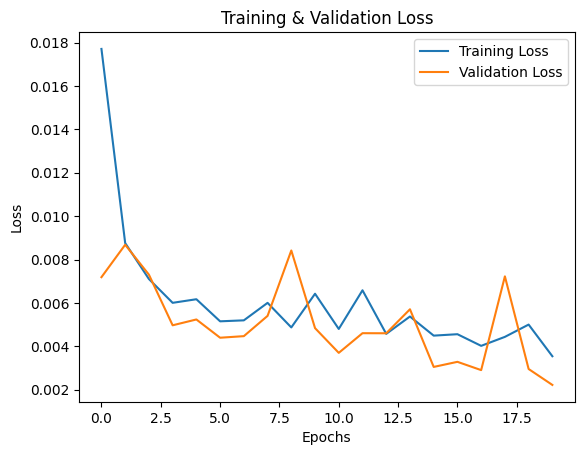

In [20]:
# Define model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)), 
    Dense(1)  # Single output for next step prediction
])

# Compile with optimized hyperparameters
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training progress
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
# Predict single-step delay for each sequence
single_step_predictions = model.predict(X_test)

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(single_step_predictions)

# Denormalize actual values
denormalized_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN 
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 125) & (comparison_df['SN'] <= 175)]

#  Print filtered DataFrame
print(comparison_df_filtered)


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
124  125              18.204927                 18.226263            0.021336
125  126              18.204927                 18.134359            0.070568
126  127              18.220901                 18.095463            0.125439
127  128              18.082142                 18.091732            0.009590
128  129              18.108130                 18.013109            0.095020
129  130              17.943144                 17.993656            0.050512
130  131              17.950058                 17.891985            0.058073
131  132              17.831087                 17.850077            0.018990
132  133              17.795801                 17.764557            0.031244
133  134              17.668962                 17.705324            0.036362
134  135              17.683029                 17.606377            0.076653
135  136              1

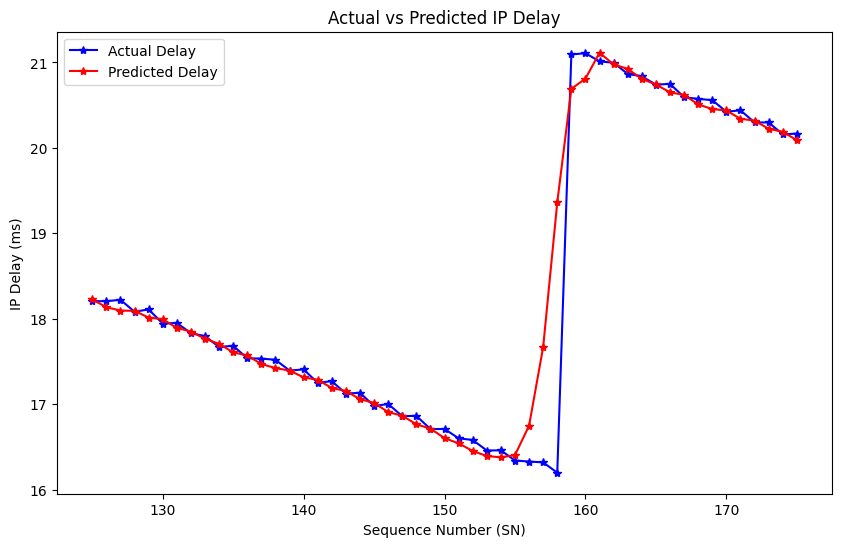

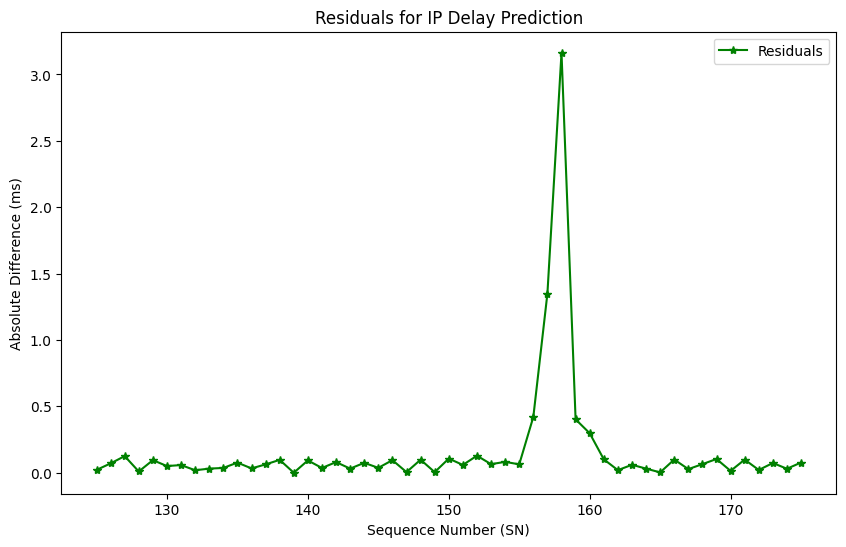

In [22]:

#  Plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay',  marker='*',color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay', marker='*', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay')
plt.legend()
plt.show()

#  Plot residuals 
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals', marker='*', color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction')
plt.legend()

## Single step approch with multiple outputs           (Sequence-to-Sequence Approach)


* Predict the next k timesteps (e.g., t+1 to t+5) from one input sequence [t0...tN]
* No Feedback loop is used

Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0580 - val_loss: 0.0221
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0186 - val_loss: 0.0141
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0082 - val_loss: 0.0050
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0045 - val_loss: 0.0074
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 10/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 11/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 12/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

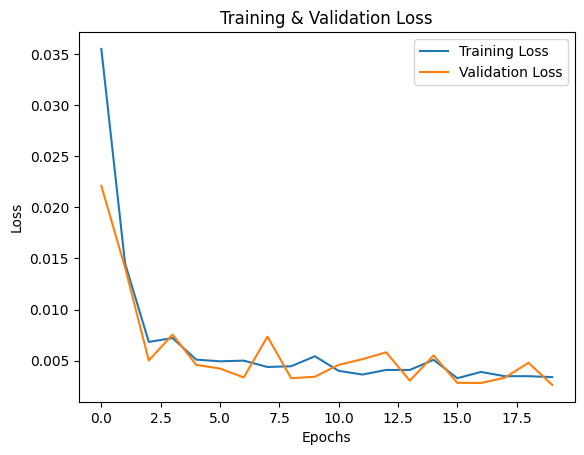

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
124  125              18.204927                 18.241121            0.036194
125  126              18.204927                 18.150616            0.054312
126  127              18.220901                 18.104301            0.116600
127  128              18.082142                 18.091919            0.009777
128  129              18.108130                 18.017654            0.090475
129  130              17.943144                 17.992329            0.049185
130  131              17.950058                 17.897118            0.052940
131  132              17.831087                 17.848980            0.017893
132  133              17.795801                 17.765232            0.030569
133  134              17.668962                 17.702732            0.033770
134  135              17.683029                 17.607149            0.075880
135  136              1

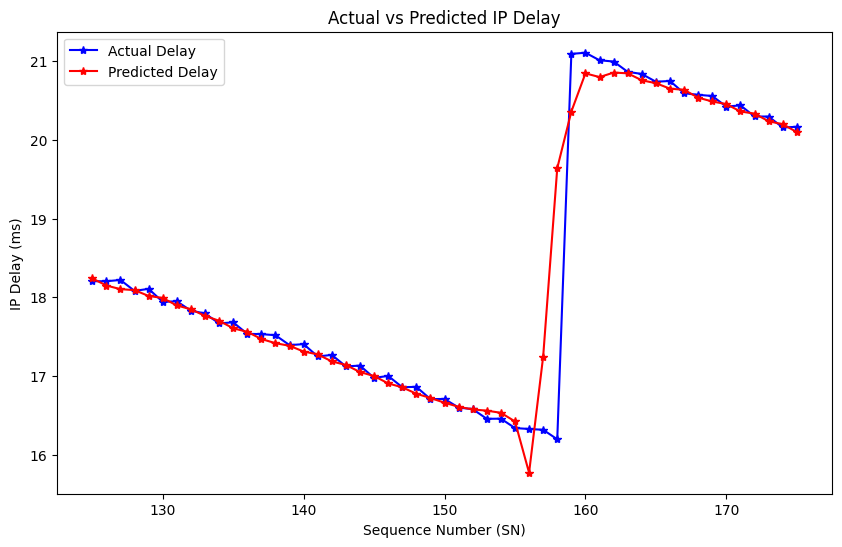

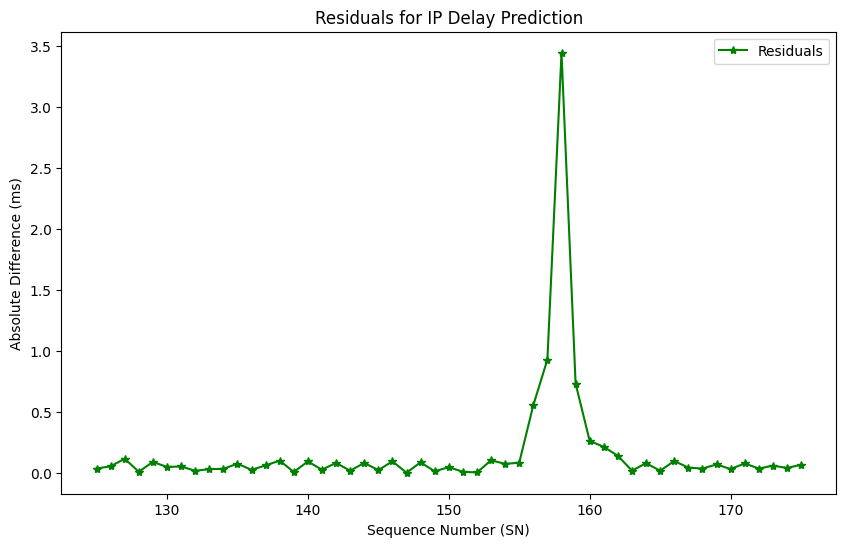

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load dataset
train_data = pd.read_csv('TE1.csv')
test_data = pd.read_csv('TR1.csv')

# Normalize IP Delay (ms)
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

# Set sequence length and output steps
sequence_length = 10  # Number of input timesteps
output_steps = 5      # Number of output timesteps

# Extract normalized values
train_values = train_data['Normalized IP Delay'].values
test_values = test_data['Normalized IP Delay'].values

# Function to create sequences
def create_seq2seq_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

# Prepare training and test data
X_train, y_train = create_seq2seq_sequences(train_values, sequence_length, output_steps)
X_test, y_test = create_seq2seq_sequences(test_values, sequence_length, output_steps)

# Reshape inputs for RNN [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Reshape outputs [samples, output_steps]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

# Build model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(output_steps)
])

model.compile(optimizer=Adam(0.01), loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict
predictions = model.predict(X_test)

# Denormalize predictions and ground truth
denormalized_predictions = scaler.inverse_transform(predictions)
denormalized_actual = scaler.inverse_transform(y_test)

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 125) & (comparison_df['SN'] <= 175)]

#  Print filtered DataFrame
print(comparison_df_filtered)

#  Plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay', marker='*', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay',  marker='*',color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay')
plt.legend()
plt.show()

#  Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals',  marker='*',color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction')
plt.legend()
plt.show()
